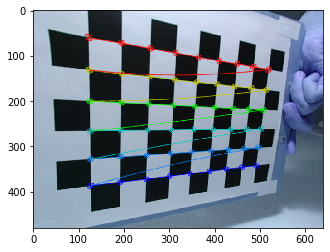

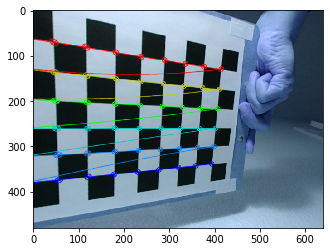

In [2]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load(left_right):
    
    # Step (1): Load the images
    img = cv2.imread("../../images/task_1/"+left_right+"_2.png")
    
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    
    object_points=[] # world frame points
    image_points=[]  # image in pixels points
    
    obpoints = np.zeros((6*9,3), np.float32) 
    obpoints[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
    # Step (2): Extract 3D-to-2D point correspondences
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
        
    if ret == True :
        mod_corners = cv2.cornerSubPix(gray,corners,(11, 11),(-1,-1),criteria)
            
        object_points.append(obpoints) 
        image_points.append(mod_corners)
            
        cv2.drawChessboardCorners(img, (9,6), corners,ret)
            
    # Step (3): Calculate camera parameters
    
    ret, mtx, dist, Rvecs, Tvecs = cv2.calibrateCamera(object_points, image_points, gray.shape[::-1],None,None)
    h,  w = img.shape[:2]
    newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))
    
    # Undistort
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Crop
    path = "../../output/task_1/"
    cv2.imwrite(path+'calibresult.png',dst)
    
    # Step (4): Check the calibration results
    
    mapx,mapy = cv2.initUndistortRectifyMap(mtx,dist,None,mtx,(w,h),5)
    dst = cv2.remap(img,mapx,mapy,cv2.INTER_LINEAR)
    
    # Step (5): Save the parameters to a file
    parameter_path = "../../parameters"
    cv2.imwrite(os.path.join(path,left_right+"_calibresult.png"), dst)
    camera_parameters = cv2.FileStorage(os.path.join(parameter_path,left_right+"_camera_parameters.xml"),
                                        cv2.FILE_STORAGE_WRITE)
    
    camera_parameters.write(left_right+"_intrinsic_parameters", mtx)
    camera_parameters.write(left_right+"_distortion_coefficients", dist)
    camera_parameters.release()
    plt.imshow(dst)
    plt.show()
        
    
load("left")
load("right")

In [3]:
# Task 2: Stereo calibration and rectification

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits import mplot3d

##same previous sequence 
def extract(left_right):
    
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    
    # Step (1): Load the images
    
    img = cv2.imread("../../images/task_2/"+left_right+"_1.png") 
    
    object_points=[]
    image_points=[]
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
 
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    
    # Step (2): Extract 3D-to-2D point correspondences
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None) 
    
    if ret == True :
        mod_corners = cv2.cornerSubPix(gray,corners,(11, 11),(-1,-1),criteria)
        object_points.append(objp) 
        image_points.append(mod_corners) 
        img = cv2.drawChessboardCorners(img, (9,6), corners,ret)
        
    return gray.shape[::-1], object_points, image_points

ret, left_intrinsic_parameters, left_distortion_coefficients, right_intrinsic_parameters\
    , right_distortion_coefficients, R, T, E, F = 0,0,0,0,0,0,0,0,0

def stereo_calibrate():

    stereocalib_criteria = (cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, 100, 1e-5)

    left_camera_parameters = cv2.FileStorage("../../parameters/left_camera_parameters.xml", cv2.FILE_STORAGE_READ)
    temp_left_intrinsic_parameters = left_camera_parameters.getNode("left_intrinsic_parameters").mat()
    temp_left_distortion_coefficients = left_camera_parameters.getNode("left_distortion_coefficients").mat()
    left_camera_parameters.release()

    right_camera_parameters = cv2.FileStorage("../../parameters/right_camera_parameters.xml", cv2.FILE_STORAGE_READ)
    temp_right_intrinsic_parameters = right_camera_parameters.getNode("right_intrinsic_parameters").mat()
    temp_right_distortion_coefficients = right_camera_parameters.getNode("right_distortion_coefficients").mat()
    right_camera_parameters.release()

    image_size, object_points, left_image_points = extract("left")
    _, _, right_image_points = extract("right")

    # Step (3): Calibrate the stereo camera
    
    ret, left_intrinsic_parameters, left_distortion_coefficients, right_intrinsic_parameters
    , right_distortion_coefficients, R, T, E, F = cv2.stereoCalibrate(\
        object_points, left_image_points, right_image_points, temp_left_intrinsic_parameters,\
        temp_left_distortion_coefficients, temp_right_intrinsic_parameters,\
        temp_right_distortion_coefficients, image_size, criteria=stereocalib_criteria)

    parameter_path = "../../parameters" 
    stereo_parameters = cv2.FileStorage(os.path.join(parameter_path,"stereo_parameters.xml"), cv2.FILE_STORAGE_WRITE)
    stereo_parameters.write("left_intrinsic_parameters", left_intrinsic_parameters)
    stereo_parameters.write("left_distortion_coefficients", left_distortion_coefficients)
    stereo_parameters.write("right_intrinsic_parameters", right_intrinsic_parameters)
    stereo_parameters.write("right_distortion_coefficients", right_distortion_coefficients)
    stereo_parameters.write("R", R)
    stereo_parameters.write("T", T)
    stereo_parameters.write("E", E)
    stereo_parameters.write("F", F)
    stereo_parameters.release()

    # Inverted pyramid:
    f = 2
    tan_x = 1
    tan_y = 1
    R_prime = np.identity(3)
    t_prime = np.zeros((3, 1))
    cam_center_local_left = np.asarray([
       [0, 0, 0],      [tan_x, tan_y, 2],
       [tan_x, -tan_y, 2],     [0, 0, 0],      [tan_x, -tan_y, 2],
       [-tan_x, -tan_y, 2],    [0, 0, 0],      [-tan_x, -tan_y, 2],
       [-tan_x, tan_y, 2],     [0, 0, 0],      [-tan_x, tan_y, 2],
       [tan_x, tan_y, 2],      [0, 0, 0]
       ]).T
    cam_center_local_right = np.asarray([
       [1.5, 0, 0],      [tan_x+1.5, tan_y+1.5, 2],
       [tan_x+1.5, -tan_y+1.5, 2],     [1.5, 0, 0],      [tan_x+1.5, -tan_y+1.5, 2],
       [-tan_x+1.5, -tan_y+1.5, 2],    [1.5, 0, 0],      [-tan_x+1.5, -tan_y+1.5, 2],
       [-tan_x+1.5, tan_y+1.5, 2],     [1.5, 0, 0],      [-tan_x+1.5, tan_y+1.5, 2],
       [tan_x+1.5, tan_y+1.5, 2],      [1.5, 0, 0]
       ]).T
    
    cam_center_local_left *= f
    cam_center_local_right *= f
    cam_center_left = np.matmul(R_prime, cam_center_local_left) + t_prime
    cam_center_right = np.matmul(R_prime, cam_center_local_right) + t_prime

    undistorted_left_image_points = cv2.undistortPoints(np.reshape(left_image_points, (54, 1, 2))
                                                  ,left_intrinsic_parameters, left_distortion_coefficients)

    undistorted_right_image_points = cv2.undistortPoints(np.reshape(right_image_points, (54, 1, 2))
                                                   ,right_intrinsic_parameters, right_distortion_coefficients) 

    normalized_undistorted_left = np.transpose(np.reshape((undistorted_left_image_points), (54, 2)))
    normalized_undistorted_right = np.transpose(np.reshape((undistorted_right_image_points), (54, 2)))
    P_0 = np.concatenate((np.identity(3),  np.zeros((3, 1))), axis=1)
    P_1 = np.concatenate((R, T), axis=1)

    # Step (4): Check Calibration results

    points_4d = cv2.triangulatePoints(P_0, P_1, normalized_undistorted_left, normalized_undistorted_right)    
    points_3d=np.divide(points_4d[:3],points_4d[3])
    
    fig = plt.figure()
    ax = plt.axes(projection="3d")
    x_line = points_3d[0]
    y_line = points_3d[1]
    z_line = points_3d[2]
    ax.scatter(x_line, y_line, z_line, c=y_line, cmap='jet')
    ax.plot(cam_center_left[0, :], cam_center_left[1, :], cam_center_left[2, :], color='k', linewidth=2)
    ax.plot(cam_center_right[0, :], cam_center_right[1, :], cam_center_right[2, :], color='k', linewidth=2)
    ax.view_init(25,-80)
    ax.set_xlim(-10, 12)
    ax.set_ylim(-10, 12)
    ax.set_zlim(-10, 12)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    plt.show()
    path = "../../output/task_2"
    fig.savefig(os.path.join(path,'plot.png'))

    # Step (5): Rectify the stereo camera
    R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(left_intrinsic_parameters\
                                          ,left_distortion_coefficients, right_intrinsic_parameters\
                                          ,right_distortion_coefficients, image_size, R, T)
    
    parameter_path = "../../parameters"
    stereo_rectified_parameters = cv2.FileStorage(os.path.join(parameter_path,"stereo_rectified_parameters.xml")
                                                  , cv2.FILE_STORAGE_WRITE)
    stereo_rectified_parameters.write("R1", R1)
    stereo_rectified_parameters.write("R2", R2)
    stereo_rectified_parameters.write("P1", P1)
    stereo_rectified_parameters.write("P2", P2)
    stereo_rectified_parameters.write("Q", Q)
    stereo_rectified_parameters.write("roi1", roi1)
    stereo_rectified_parameters.write("roi2", roi2)
    stereo_rectified_parameters.release()

    # Step (6): Check the rectification results
    map_left_1, map_left_2  = cv2.initUndistortRectifyMap(left_intrinsic_parameters\
                                ,left_distortion_coefficients, R1, P1, image_size, cv2.CV_32FC1)
    
    map_right_1, map_right_2 = cv2.initUndistortRectifyMap(right_intrinsic_parameters\
                                ,right_distortion_coefficients, R2, P2, image_size, cv2.CV_32FC1)
    
    distort_left_images_0 = cv2.imread("../../images/task_2/left_0.png")
    distort_left_images_1 = cv2.imread("../../images/task_2/left_1.png")
    
    cv2.imwrite(os.path.join(path,'distort_left_images_0.png'), distort_left_images_0)
    cv2.imwrite(os.path.join(path,'distort_left_images_1.png'), distort_left_images_1)
    
    undistort_left_images_0 = cv2.undistort(distort_left_images_0, left_intrinsic_parameters\
                                            ,left_distortion_coefficients)
    undistort_left_images_1 = cv2.undistort(distort_left_images_1, right_intrinsic_parameters\
                                            ,right_distortion_coefficients)
    
    cv2.imwrite(os.path.join(path,'undistort_left_images_0.png'), undistort_left_images_0)
    cv2.imwrite(os.path.join(path,'undistort_left_images_1.png'), undistort_left_images_1)
    
    rectified_left_images_0 = cv2.remap(distort_left_images_0, map_left_1, map_left_2, cv2.INTER_LINEAR)
    rectified_left_images_1 = cv2.remap(distort_left_images_1, map_left_1, map_left_2, cv2.INTER_LINEAR)
    ,
    cv2.imwrite(os.path.join(path,'rectified_left_images_0.png'), rectified_left_images_0)
    cv2.imwrite(os.path.join(path,'rectified_left_images_1.png'), rectified_left_images_1)
stereo_calibrate()

error: OpenCV(4.5.4-dev) /tmp/pip-req-build-5mtujfce/opencv/modules/calib3d/src/undistort.dispatch.cpp:402: error: (-215:Assertion failed) CV_IS_MAT(_cameraMatrix) && _cameraMatrix->rows == 3 && _cameraMatrix->cols == 3 in function 'cvUndistortPointsInternal'


In [ ]:
# Task 2: Stereo calibration and rectification

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits import mplot3d
 
def extract(left_right):
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    # Step (1): Load the images
    images = [file for file in sorted(glob.glob("../../images/task_2/"+left_right+"_1.png"))]
    object_points=[]
    image_points=[]
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    for image in images: 
        img = cv2.imread(image) 
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
        # Step (2): Extract 3D-to-2D point correspondences
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None) 
        if ret == True :
            mod_corners = cv2.cornerSubPix(gray,corners,(11, 11),(-1,-1),criteria)
            object_points.append(objp) 
            image_points.append(mod_corners) 
            img = cv2.drawChessboardCorners(img, (9,6), corners,ret)
    return gray.shape[::-1], object_points, image_points

def stereo_calibrate():

    stereocalib_criteria = (cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, 100, 1e-5)

    left_camera_parameters = cv2.FileStorage("../../parameters/left_camera_parameters.xml", cv2.FILE_STORAGE_READ)
    temp_left_intrinsic_parameters = left_camera_parameters.getNode("left_intrinsic_parameters").mat()
    temp_left_distortion_coefficients = left_camera_parameters.getNode("left_distortion_coefficients").mat()
    left_camera_parameters.release()

    right_camera_parameters = cv2.FileStorage("../../parameters/right_camera_parameters.xml", cv2.FILE_STORAGE_READ)
    temp_right_intrinsic_parameters = right_camera_parameters.getNode("right_intrinsic_parameters").mat()
    temp_right_distortion_coefficients = right_camera_parameters.getNode("right_distortion_coefficients").mat()
    right_camera_parameters.release()

    image_size, object_points, left_image_points = extract("left")
    _, _, right_image_points = extract("right")

    # Step (3): Calibrate the stereo camera 
    ret, left_intrinsic_parameters, left_distortion_coefficients, right_intrinsic_parameters, right_distortion_coefficients, R, T, E, F = cv2.stereoCalibrate(
        object_points, left_image_points, right_image_points, temp_left_intrinsic_parameters, 
        temp_left_distortion_coefficients, temp_right_intrinsic_parameters, 
        temp_right_distortion_coefficients, image_size, criteria=stereocalib_criteria)

    parameter_path = "../../parameters" 
    stereo_parameters = cv2.FileStorage(os.path.join(parameter_path,"stereo_parameters.xml"), cv2.FILE_STORAGE_WRITE)
    stereo_parameters.write("left_intrinsic_parameters", left_intrinsic_parameters)
    stereo_parameters.write("left_distortion_coefficients", left_distortion_coefficients)
    stereo_parameters.write("right_intrinsic_parameters", right_intrinsic_parameters)
    stereo_parameters.write("right_distortion_coefficients", right_distortion_coefficients)
    stereo_parameters.write("R", R)
    stereo_parameters.write("T", T)
    stereo_parameters.write("E", E)
    stereo_parameters.write("F", F)
    stereo_parameters.release()\

    # Inverted pyramid:
    f = 2
    tan_x = 1
    tan_y = 1
    R_prime = np.identity(3)
    t_prime = np.zeros((3, 1))
    cam_center_local_left = np.asarray([
       [0, 0, 0],      [tan_x, tan_y, 2],
       [tan_x, -tan_y, 2],     [0, 0, 0],      [tan_x, -tan_y, 2],
       [-tan_x, -tan_y, 2],    [0, 0, 0],      [-tan_x, -tan_y, 2],
       [-tan_x, tan_y, 2],     [0, 0, 0],      [-tan_x, tan_y, 2],
       [tan_x, tan_y, 2],      [0, 0, 0]
       ]).T
    cam_center_local_right = np.asarray([
       [1.5, 0, 0],      [tan_x+1.5, tan_y+1.5, 2],
       [tan_x+1.5, -tan_y+1.5, 2],     [1.5, 0, 0],      [tan_x+1.5, -tan_y+1.5, 2],
       [-tan_x+1.5, -tan_y+1.5, 2],    [1.5, 0, 0],      [-tan_x+1.5, -tan_y+1.5, 2],
       [-tan_x+1.5, tan_y+1.5, 2],     [1.5, 0, 0],      [-tan_x+1.5, tan_y+1.5, 2],
       [tan_x+1.5, tan_y+1.5, 2],      [1.5, 0, 0]
       ]).T
    cam_center_local_left *= f
    cam_center_local_right *= f
    cam_center_left = np.matmul(R_prime, cam_center_local_left) + t_prime
    cam_center_right = np.matmul(R_prime, cam_center_local_right) + t_prime

    undistorted_left_image_points = cv2.undistortPoints(np.reshape(left_image_points, (54, 1, 2)),
                                                  left_intrinsic_parameters, left_distortion_coefficients)

    undistorted_right_image_points = cv2.undistortPoints(np.reshape(right_image_points, (54, 1, 2)),
                                                   right_intrinsic_parameters, right_distortion_coefficients) 

    normalized_undistorted_left = np.transpose(np.reshape((undistorted_left_image_points), (54, 2)))
    normalized_undistorted_right = np.transpose(np.reshape((undistorted_right_image_points), (54, 2)))
    P_0 = np.concatenate((np.identity(3),  np.zeros((3, 1))), axis=1)
    P_1 = np.concatenate((R, T), axis=1)

    # Step (4): Check Calibration results

    points_4d = cv2.triangulatePoints(P_0, P_1, normalized_undistorted_left, normalized_undistorted_right)    
    points_3d=np.divide(points_4d[:3],points_4d[3])
    fig = plt.figure()
    ax = plt.axes(projection="3d")
    x_line = points_3d[0]
    y_line = points_3d[1]
    z_line = points_3d[2]
    ax.scatter(x_line, y_line, z_line, c=y_line, cmap='jet')
    ax.plot(cam_center_left[0, :], cam_center_left[1, :], cam_center_left[2, :],
                   color='k', linewidth=2)
    ax.plot(cam_center_right[0, :], cam_center_right[1, :], cam_center_right[2, :],
                   color='k', linewidth=2)
    ax.view_init(25,-80)
    ax.set_xlim(-10, 12)
    ax.set_ylim(-10, 12)
    ax.set_zlim(-10, 12)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    plt.show()
    path = "../../output/task_2"
    fig.savefig(os.path.join(path,'plot.png'))

    # Step (5): Rectify the stereo camera
    R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(left_intrinsic_parameters, 
                                                      left_distortion_coefficients, right_intrinsic_parameters, 
                                                      right_distortion_coefficients, image_size, R, T)
    parameter_path = "../../parameters"
    stereo_rectified_parameters = cv2.FileStorage(os.path.join(parameter_path,"stereo_rectified_parameters.xml"), cv2.FILE_STORAGE_WRITE)
    stereo_rectified_parameters.write("R1", R1)
    stereo_rectified_parameters.write("R2", R2)
    stereo_rectified_parameters.write("P1", P1)
    stereo_rectified_parameters.write("P2", P2)
    stereo_rectified_parameters.write("Q", Q)
    stereo_rectified_parameters.write("roi1", roi1)
    stereo_rectified_parameters.write("roi2", roi2)
    stereo_rectified_parameters.release()

    # Step (6): Check the rectification results
    map_left_1, map_left_2  = cv2.initUndistortRectifyMap(
        left_intrinsic_parameters,left_distortion_coefficients, R1, P1, image_size, cv2.CV_32FC1)
    map_right_1, map_right_2 = cv2.initUndistortRectifyMap(
        right_intrinsic_parameters, right_distortion_coefficients, R2, P2, image_size, cv2.CV_32FC1)
    distort_left_images_0 = cv2.imread("../../images/task_2/left_0.png")
    distort_right_images_1 = cv2.imread("../../images/task_2/right_1.png")
    cv2.imwrite(os.path.join(path,'distort_left_images_0.png'), distort_left_images_0)
    cv2.imwrite(os.path.join(path,'distort_right_images_1.png'), distort_right_images_1)
    undistort_left_images_0 = cv2.undistort(distort_left_images_0, left_intrinsic_parameters,
                                            left_distortion_coefficients)
    undistort_right_images_1 = cv2.undistort(distort_right_images_1, right_intrinsic_parameters,
                                            right_distortion_coefficients)
    cv2.imwrite(os.path.join(path,'undistort_left_images_0.png'), undistort_left_images_0)
    cv2.imwrite(os.path.join(path,'undistort_right_images_1.png'), undistort_right_images_1)
    rectified_left_images_0 = cv2.remap(distort_left_images_0, map_left_1, map_left_2, cv2.INTER_LINEAR)
    rectified_right_images_1 = cv2.remap(distort_right_images_1, map_right_1, map_right_2, cv2.INTER_LINEAR)
    cv2.imwrite(os.path.join(path,'rectified_left_images_0.png'), rectified_left_images_0)
    cv2.imwrite(os.path.join(path,'rectified_right_images_1.png'), rectified_right_images_1)
stereo_calibrate()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


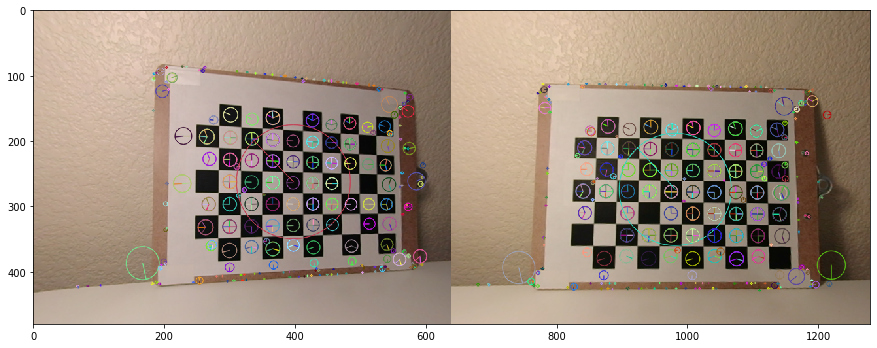

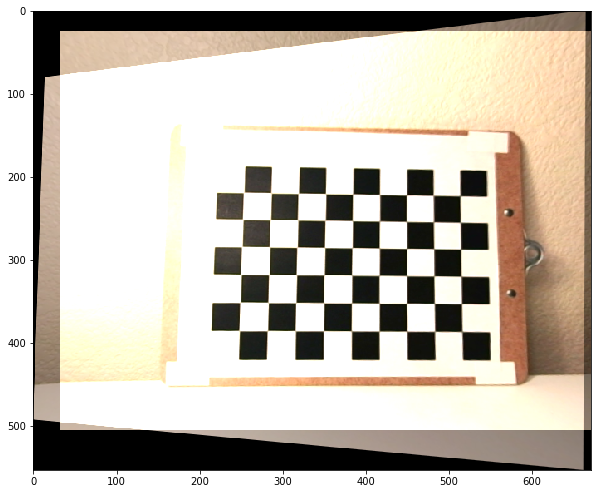

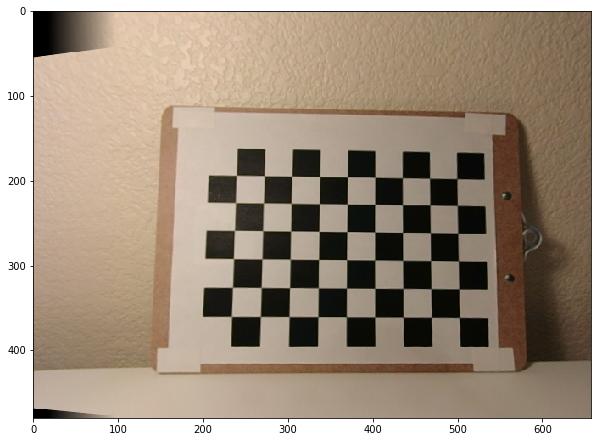

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import stitch
import features

def convertResult(img):
    '''Because of your images which were loaded by opencv, 
    in order to display the correct output with matplotlib, 
    you need to reduce the range of your floating point image from [0,255] to [0,1] 
    and converting the image from BGR to RGB:'''
    
    img = np.array(img,dtype=float)/float(255)
    img = img[:,:,::-1]
    
    return img

#load images
left_img = cv2.imread("../../output/task_2/"+"0_undistort_left_images_0.png")
right_img = cv2.imread("../../output/task_2/"+"1_undistort_right_images_1.png")

#extract keypoints and descriptors using sift
k0,f0=features.findAndDescribeFeatures(left_img,opt='SIFT')
k1,f1=features.findAndDescribeFeatures(right_img,opt='SIFT')

#draw keypoints
img0_kp=features.drawKeypoints(left_img.copy(),k0)
img1_kp=features.drawKeypoints(right_img.copy(),k1)

plt_img = np.concatenate((img0_kp, img1_kp), axis=1)
plt.figure(figsize=(15,15))
plt.imshow(convertResult(plt_img))

#matching features using BruteForce 
mat=features.matchFeatures(f0,f1,ratio=0.6,opt='BF')

#Computing Homography matrix and mask
H,matMask=features.generateHomography(left_img,right_img)

#wrap 2 image
#choose list_images[0] as desination
pano,non_blend,left_side,right_side=stitch.warpTwoImages(left_img,right_img,True)

#display pano without cropping and blending
plt.figure(figsize=(10,10))
plt.imshow(convertResult(non_blend))
plt.savefig('../../output/task_3/non_blend.png')

plt.figure(figsize=(10,10))
plt.imshow(convertResult(pano))
plt.savefig('../../output/task_3/pano.png')

In [ ]:
undistort_left_4 = cv2.imread("~/Farmtopia/Camera-Model-and-Stereo-Depth-Sensing/output/task_2/undistort_left_images_0.png")
undistort_right_4 = cv2.imread("~/Farmtopia/Camera-Model-and-Stereo-Depth-Sensing/output/task_2/undistort_right_images_1.png")
rectified_left_4 = cv2.imread("~/Farmtopia/Camera-Model-and-Stereo-Depth-Sensing/output/task_2/rectified_left_images_0.png")
rectified_right_4 = cv2.imread("~/Farmtopia/Camera-Model-and-Stereo-Depth-Sensing/output/task_2/rectified_right_images_1.png")

# Step 2: Block match for each pixel on the images to obtain a disparity map
matcher_left = cv2.StereoSGBM_create(minDisparity=0,
                                     numDisparities=160,
                                     blockSize=5,
                                     P1=8 * 3 * 3 ** 2,
                                     P2=32 * 3 * 3 ** 2,
                                     disp12MaxDiff=1,
                                     uniquenessRatio=15,
                                     speckleWindowSize=0,
                                     speckleRange=2,
                                     preFilterCap=63,
                                     mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
                                     )

matcher_right = cv2.ximgproc.createRightMatcher(matcher_left)
lamda = 1000
sigma = 1.2
v_multi = 0.5
filter_w = cv2.ximgproc.createDisparityWLSFilter(matcher_left=matcher_left)
filter_w.setLambda(lamda)
filter_w.setSigmaColor(sigma)
display_disparity = matcher_left.compute(rectified_left_4, rectified_right_4)  
display_rectified = matcher_right.compute(rectified_right_4, rectified_left_4)  
display_disparity = np.int16(display_disparity)
display_rectified = np.int16(display_rectified)
disparity = filter_w.filter(display_disparity, rectified_left_4, None, display_rectified) 
disparity = cv2.normalize(src=disparity, dst=disparity, beta=0, alpha=255, norm_type=cv2.NORM_MINMAX);
disparity = np.uint8(disparity)
# Step 3: Calculate depth for each pixel using the disparity map
depth = cv2.reprojectImageTo3D(display_disparity, Q)
path = "../../output/task_4"
cv2.imwrite(os.path.join(path,"Rectified image left.png"), rectified_left_4)
cv2.imwrite(os.path.join(path,"Rectified image right.png"), rectified_right_4)
cv2.imwrite(os.path.join(path,"Disparity.png"), disparity)
# Step 4: Check the dense depth results
cv2.imshow("Rectified Image Left",rectified_left_4)
cv2.imshow("Rectified Image Right",rectified_right_4)
cv2.imshow("Disparity",disparity)
cv2.waitKey(0)